# Sesimic refraction analysis

## Required modules and global setup for plots

In [1]:
# Standard libraries
import os
import sys
import itertools
import re
import subprocess
# Scientific computing libraries
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl

# Widgets and other libraries
from ipywidgets import widgets as wgt
from IPython import get_ipython

if 'google.colab' in str(get_ipython()):
    print('Running on CoLab. Installing the required modules...')
    subprocess.run('pip install ipympl', shell=True);
else:
    import tkinter as tk
    from tkinter.filedialog import askopenfilename

# plt.style.use("default")
mpl.rcParams.update(
    {
        'figure.constrained_layout.use': True,
        'interactive': False,
        "text.usetex": False,  # Use mathtext, not LaTeX
        "font.family": "cmr10",  # Use the Computer modern font
        "mathtext.fontset": "cm",
        "axes.formatter.use_mathtext": True,
        "axes.unicode_minus": False,
    }
)

## A homogeneous subsurface

![Wavefield Animation](refraction_data/homogeneous.gif)

The subsurface is represented as a homogeneous medium with constant velocity. A seismic source is placed near the surface at $(x = 5\text{ m}, z = 1\text{ m})$. An array of geophones (receivers) is distributed along the surface at a depth of $z = 1 \text{ m}$, starting at $x = 10 \text{ m}$ and continuing every $5 \text{ m}$ up to $x = 65 \text{ m}$.  
 
To estimate the medium velocity using the graphical method of seismic refraction:

 1. Plot the recorded time–distance diagram, where each trace is shifted according to its receiver position.  
 2. Identify the first arrivals (earliest energy at each receiver).  
 3. Draw a straight line that best fits these first arrivals.  
 4. Compute the slope of the line.  
 5. The apparent velocity of the medium is the inverse of the slope:

$$
V_1 = \frac{1}{\text{slope}}
$$

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
dataset = np.load("refraction_data/homogeneous.npz")
data = dataset["seismograms"]      # normalized seismograms
time = dataset["time"]             # time vector
receiver_positions = dataset["receivers"]  # receiver x-positions

slope = 0.6691 s/m
estimated medium velocity = 1.49 m/s
ground truth medium velocity = 1.50 m/s


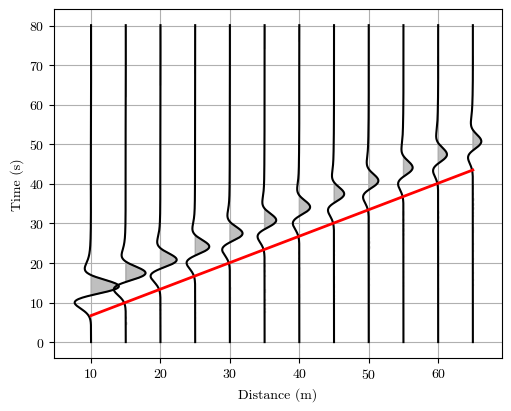

In [3]:
plt.figure(figsize=(5, 4))

scale = 4  # horizontal scaling of wiggles

for i, xpos in enumerate(receiver_positions):
    trace = data[:, i]
    plt.plot(trace * scale + xpos, time, 'k')  # wiggle line
    plt.fill_betweenx(time, xpos, trace * scale + xpos, 
                      where=trace > 0, color='gray', alpha=0.5)

# ==============================
# Add a line between two points
# ==============================
x1, t1 = 10, 6.7    # <-- first arrival pick
x2, t2 = 65.0, 43.5 # <-- second arrival pick

# Slope and apparent velocity
m = (t2 - t1) / (x2 - x1)
v = (x2 - x1) / (t2 - t1)

print(f"slope = {m:.4f} s/m")
print(f"estimated medium velocity = {v:.2f} m/s")
print(f"ground truth medium velocity = 1.50 m/s")


plt.plot([x1, x2], [t1, t2], 'r-', linewidth=2, label="Defined line")
# ==============================

plt.gca()#.invert_yaxis()  # seismic convention: time increases downward
plt.xlabel("Distance (m)", fontsize=10)
plt.ylabel("Time (s)", fontsize=10)

plt.grid(True)
plt.show()


## A single subsurface interface

 ![Wavefield Anination Single Interface](refraction_data/single_interface.gif)


This example shows the travel-time curves of direct and refracted waves recorded at different distances from a seismic source. The velocity of the first layer is related to the slope by:

$$
v_1 = \frac{1}{m_d}
$$

where $m_d$ is the slope of the direct-wave line. Similarly, the travel-time of the refracted wave is given by:

$$
v_2 = \frac{1}{m_r}
$$

where $m_r$ is the slope of the refracted-wave line. Finally, the depth to the refractor can be estimated from:

$$
\text{Depth} = \tfrac{1}{2} \, X_{cross} \, \sqrt{\frac{v_2 - v_1}{v_2 + v_1}}
$$

### Summary of steps for seismic refraction analysis

- **Step 1:** Find the slope of the direct wave.  
- **Step 2:** Find the slope of the head wave.  
- **Step 3:** Find the crossover distance.  
- **Step 4:** Compute the depth to the boundary.  

### Example

Seismic arrival times were measured using a source and geophones spaced every 3 m up to 69 m to study wave propagation in a two-layer model. Direct waves traveled at 1400 m/s, while refracted waves appeared beyond the critical distance at 4500 m/s. Their crossover point indicated a refractor depth of about 10 m, revealing the subsurface velocity structure.

Direct wave slope = 0.7143 ms/m, estimated velocity = 1399.99 m/s, ground truth = 1400 m/s
Refracted wave slope = 0.2222 ms/m, estimated velocity = 4500.16 m/s, ground truth = 4500 m/s
Crossover distance = 27.59 m
Depth to refractor = 10.00 m, ground truth = 10.00 m


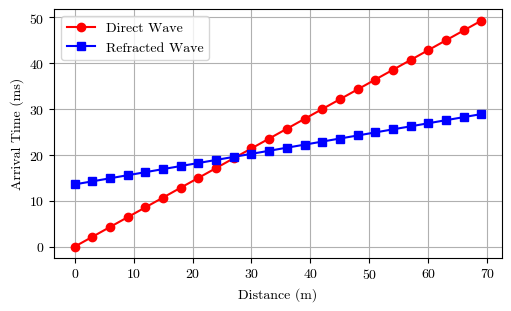

In [ ]:
# Load data
arr = np.load("refraction_data/single-layer.npy")

# Split columns
distance = arr[:, 0]     # Source-receiver distance (m)
direct = arr[:, 1]       # Direct wave arrival times (ms)
refracted = arr[:, 2]    # Refracted wave arrival times (ms)

# Linear regression (fit a line) for each wave
coef_direct = np.polyfit(distance, direct, 1)      # slope, intercept
coef_refracted = np.polyfit(distance, refracted, 1)

m_direct, b_direct = coef_direct
m_refracted, b_refracted = coef_refracted

# Velocities (convert slope from ms/m to m/s)
v_direct = 1 / m_direct * 1000
v_refracted = 1 / m_refracted * 1000

print(f"Direct wave slope = {m_direct:.4f} ms/m, estimated velocity = {v_direct:.2f} m/s, ground truth = 1400 m/s")
print(f"Refracted wave slope = {m_refracted:.4f} ms/m, estimated velocity = {v_refracted:.2f} m/s, ground truth = 4500 m/s")

# Assign velocities
v1 = v_direct       # velocity of the first layer
v2 = v_refracted    # velocity of the second layer

# Crossover distance (Xcross)
# Solve m1*x + b1 = m2*x + b2
X_cross = (b_refracted - b_direct) / (m_direct - m_refracted)

# Depth calculation (from crossover method)
depth = 0.5 * np.sqrt((v2 - v1) / (v2 + v1)) * X_cross

print(f"Crossover distance = {X_cross:.2f} m")
print(f"Depth to refractor = {depth:.2f} m, ground truth = 10.00 m")

# Plot arrival times
plt.figure(figsize=(5, 3))
plt.plot(distance, direct, 'o-r', label="Direct Wave")
plt.plot(distance, refracted, 's-b', label="Refracted Wave")

plt.xlabel("Distance (m)")
plt.ylabel("Arrival Time (ms)")
plt.legend()
plt.grid(True)
plt.show()